# Calculator-based validation of the MTPs
* Evaluate numerical stresses and regular stresses
* rmses and crystal analysis
* currently waiting on lammps implementation of MTPs on Omega

In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
from ase.io.extxyz import read_xyz
import numpy as np
from ase.atoms import Atoms
from ase.io.formats import index2range
from ase.io.cfg import read_cfg
from io import StringIO, UnsupportedOperation
from mtp import *
import os
from os import chdir, getcwd, listdir
from os.path import join
from matplotlib import pyplot as plt
from quippy.potential import Potential
import pickle
from Ge_calculation import *
from Ge_analysis import *
import matplotlib.pyplot as plt
from matscipy.rings import ring_statistics
from datetime import datetime
import pymatgen.ext.matproj as mp
import pymatgen.io.ase as pase
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from numpy.random import normal
from ase.io.extxyz import write_xyz
from ase.io.lammpsdata import write_lammps_data
from calc_all_lib import update_progress
import traceback

In [242]:
import sys

sys.path.append('/u/vld/hert5155/JDM_utils')

from rmc_utils import *
from analysis_utils import is_outlier

In [9]:
mpl.style.reload_library()
mpl.style.use('VLD')

In [10]:
chdir('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP')

In [11]:
GAP_18_dir = '/u/vld/hert5155/jup_remote/Ge_od/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP'
g18_pot = Potential(param_filename=GAP_18_dir+'/gp_iter6_sparse9k.xml')

/u/vld/hert5155/ase/ase/calculators/calculator.py:507: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  warnings.warn(FutureWarning(


## Testing database from libatoms testing framework 

In [12]:
with open('testing_database.xyz', 'r') as f:
    g18_test_db = list(read_xyz(f, index=slice(0,None)))

GAP-18 training database (common to most MTPs)

In [13]:
with open('GAP_18_db_GAPlabelled.pickle', 'rb') as f:
    g18_db = pickle.load(f)

In [81]:
with open('MQ_MP_PQ1k_amo_rand_testing.xyz', 'r') as f:
    test_db = list(read_xyz(f, index=slice(0,None)))

# Labelling

In [104]:
class Model:
    
    def __init__(self, potential, test_set, train_set=[], name='', read_test_set=False):
        
        self.potential = potential
        self.pot = potential
        
        self.test_set = test_set
        self.train_set = train_set
        self.atoms_lengths = np.array([len(i) for i in test_set])
        self.train_atoms_lengths = np.array([len(i) for i in train_set])
        
        self.name = name
        
        self.results = []
        self.ref_results = []
        self.train_results = []
        self.es = []; self.ref_es = []; self.train_es = []
        self.fs = []; self.ref_fs = []; self.train_fs = []
        self.ss = []; self.ref_ss = []; self.train_ss = []
        
        if read_test_set:
            efs_read()
        
        return
    
    def efs_calc(self, numerical_stress=False, extra_properties=[], train=False):
        
        if train:
            ats = self.train_set
            n = 'training'
            cfgs='train'
        else:
            ats = self.test_set
            n = 'testing'
            cfgs='test'
            
        N = len(ats)
        print('Calculating {} {} configurations'.format(N, n))

        for ct, i in enumerate(ats):
            i.calc = self.pot

            self.pot.calculate(i, properties=['energy', 'forces', 'stress']+extra_properties)

            if train:
                self.train_results.append(self.pot.results.copy())
                if hasattr(self.pot, 'extra_results'):
                    self.train_results[-1] = {**self.train_results[-1], **self.pot.extra_results}
            else:
                self.results.append(self.pot.results.copy())
                if hasattr(self.pot, 'extra_results'):
                    self.results[-1] = {**self.results[-1], **self.pot.extra_results}
            
            i.calc = None
            update_progress(ct/N)
        
        update_progress(1)
        self.update_efs(cfgs=cfgs)
        
        return
       
    def efs_read(self, cfgs='test', **kwargs):
        
        if cfgs=='reference':
            self.ref_results = []
            for i in self.test_set:
                self.ref_results.append({**i.info, **i.arrays})
            
            self.update_efs(cfgs, **kwargs)
        
        elif cfgs=='test':
            self.results = []

            for i in self.test_set:
                self.results.append({**i.info, **i.arrays})
            
            self.update_efs(cfgs, **kwargs)
        
        elif cfgs=='train':
            self.train_results = []

            for i in self.train_set:
                self.train_results.append({**i.info, **i.arrays})
            
            self.update_efs(cfgs, **kwargs)
            
        elif cfgs=='reference_train':
            self.ref_train_results = []

            for i in self.train_set:
                self.ref_train_results.append({**i.info, **i.arrays})
            
            self.update_efs(cfgs, **kwargs)
            
    def rmse(self, silent=False):
        
        self.rmses = {
            'energy_test': rms_dict(self.es/self.atoms_lengths, self.ref_es/self.atoms_lengths),
            'force_test' : rms_dict(self.flat_fs, self.ref_flat_fs),
            'stress_test': rms_dict(
                (self.ss.T/self.atoms_lengths).T, 
                (self.ref_ss.T/self.atoms_lengths).T),
            
            'energy_train': rms_dict(self.train_es/self.train_atoms_lengths,
                                     self.ref_train_es/self.train_atoms_lengths),
            'force_train' : rms_dict(self.train_flat_fs, self.ref_train_flat_fs),
            'stress_train': rms_dict(
                (self.train_ss.T/self.train_atoms_lengths).T, 
                (self.ref_train_ss.T/self.train_atoms_lengths).T)
        }
        
        if not silent:
            print(('{:<20s}'*3).format('Quantity','RMSE per at','Std'))
            print('-'*60)
            for i,j in self.rmses.items():
                print('{:<20s}{:<20.3f}{:<20.3f}'.format(i, j['rmse'], j['std']))
        
        return
     
    def save_efs(self, save_all=True, save_dict={}, file=None):
        
        if file is None:
            file = self.pot.name+'.pickle'
            
        if save_all:
            save_dict.update({'test_set' : self.test_set,
                        'train_set' : self.train_set,
                        'results'   : self.results,
                        'ref_results': self.ref_results,
                        'train_results' : self.train_results})
        
        with open(file, 'wb') as f:
            pickle.dump(save_dict, f)
        
        return
    
    def load_efs(self, file=None):
        
        if file is None:
            file = self.pot.name+'.pickle'
            
        with open(file, 'rb') as f:
            save_dict = pickle.load(f)
            
        self.test_set = save_dict['test_set']
        self.train_set = save_dict['train_set']
        self.test_set = save_dict['results']
        self.results = save_dict['ref_results']
        self.train_results = save_dict['train_results']
        
        
        return
    
    def update_efs(self, cfgs='test',
                  energy_name='energy', force_name='forces', stress_name='stress'):
    
        if cfgs=='reference':
            self.ref_es = []; self.ref_fs = []; self.ref_ss = []
            for i in self.ref_results:

                self.ref_es.append(i[energy_name])
                self.ref_fs.append(i[force_name])
                try:
                    self.ref_ss.append(to_voigt(i[stress_name]))
                except:
                    self.ref_ss.append(np.NaN*np.ones(6))
                    traceback.print_exc()
                    
            self.ref_es = np.array(self.ref_es)
            self.ref_flat_fs = np.array(flatten(self.ref_fs))
            self.ref_ss = np.array(self.ref_ss)
            self.ref_flat_ss = self.ref_ss.ravel()
            self.ref_ps = np.array([-1*i[0:3].mean() for i in self.ref_ss])
            
        elif cfgs=='test':
            self.es = []; self.fs = []; self.ss = []
            for i in self.results:

                self.es.append(i[energy_name])
                self.fs.append(i[force_name])
                try:
                    self.ss.append(to_voigt(i[stress_name]))
                except:
                    self.ss.append(np.NaN*np.ones(6))
                    
            self.es = np.array(self.es)
            self.flat_fs = np.array(flatten(self.fs))
            self.ss = np.array(self.ss)
            self.flat_ss = self.ss.ravel()
            self.ps = np.array([-1*i[0:3].mean() for i in self.ss])
            
        if cfgs=='train':
            self.train_es = []; self.train_fs = []; self.train_ss = []
            for i in self.train_results:

                self.train_es.append(i[energy_name])
                self.train_fs.append(i[force_name])
                try:
                    self.train_ss.append(to_voigt(i[stress_name]))
                except:
                    self.train_ss.append(np.NaN*np.ones(6))
                    
            self.train_es = np.array(self.train_es)
            self.train_flat_fs = np.array(flatten(self.train_fs))
            self.train_ss = np.array(self.train_ss)
            self.train_flat_ss = self.train_ss.ravel()
            self.train_ps = np.array([-1*i[0:3].mean() for i in self.train_ss])
            
        if cfgs=='reference_train':
            self.ref_train_es = []; self.ref_train_fs = []; self.ref_train_ss = []
            for i in self.ref_train_results:

                self.ref_train_es.append(i[energy_name])
                self.ref_train_fs.append(i[force_name])
                
                try:
                    self.ref_train_ss.append(to_voigt(i[stress_name]))
                except:
                    self.ref_train_ss.append(np.NaN*np.ones(6))

            self.ref_train_es = np.array(self.ref_train_es)
            self.ref_train_flat_fs = np.array(flatten(self.ref_train_fs))
            self.ref_train_ss = np.array(self.ref_train_ss)
            self.ref_train_flat_ss = self.ref_train_ss.ravel()
            self.ref_train_ps = np.array([-1*i[0:3].mean() for i in self.ref_train_ss])
        
        return
            

In [55]:
def to_voigt(mat):
    
#     if not isinstance(mats, list):
#         mats = [mats]
    
    if mat.shape==(9,):
        vgt = np.array([mat[0], mat[3], mat[6], mat[5], mat[2], mat[1]])
        
    elif mat.shape==(3,3):       
        vgt = np.concatenate((mat.diagonal(), np.array([mat[1,2], mat[0,2], mat[0,1]])))
        
    elif mat.shape==(6,):
        vgt = mat
    
    else:
        raise AttributeError('Shapes do not match recognised stress tensor conventions')
        
    return vgt

In [36]:
g18_test = Model(g18_pot, g18_test_db, train_set=g18_db, name='g18')

In [37]:
g18_test.efs_calc()

Calculating 28 configurations
Percent: [##############################] 100.00% Done...


In [38]:
g18_test.efs_read(cfgs='reference', force_name='dft_force', stress_name='virial')
g18_test.efs_read(cfgs='train', energy_name='gap18_energy', force_name='gap18_force', stress_name='gap18_virial')
g18_test.efs_read(cfgs='reference_train', energy_name='dft_energy', force_name='dft_force', stress_name='dft_virial')

In [39]:
g18_test.rmse()

Quantity            RMSE                Std                 
------------------------------------------------------------
energy_test         0.006               0.000               
force_test          0.105               0.051               
stress_test         0.093               0.033               
energy_train        0.001               0.000               
force_train         0.082               0.022               
stress_train        0.815               2.261               


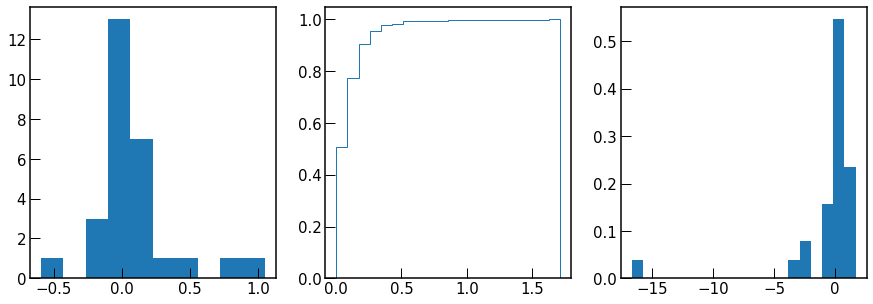

In [360]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))

h1= axs.hist(g18_test.es - g18_test.ref_es)

h2 = axs2.hist(np.linalg.norm(g18_test.flat_fs - g18_test.ref_flat_fs, axis=1),
               bins=20, cumulative=True, histtype='step', orientation='vertical', density=True)

h3 = axs3.hist((g18_test.ss[:,0:3] - [to_voigt(i)[0:3] for i in g18_test.ref_ss]).mean(axis=1),
               bins=20, orientation='vertical', density=True)

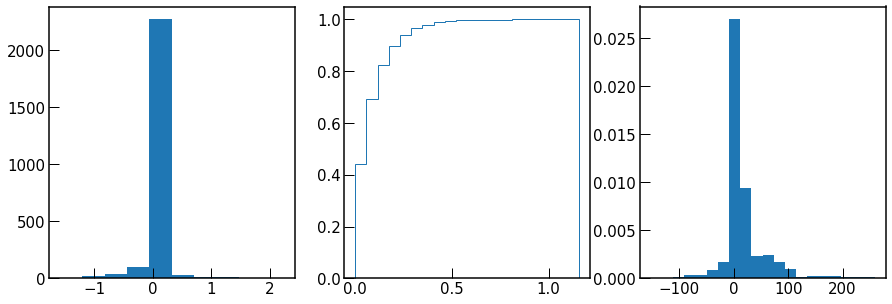

In [361]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))

h1= axs.hist(g18_test.ref_train_es - g18_test.train_es)

h2 = axs2.hist(np.linalg.norm(g18_test.ref_train_flat_fs - g18_test.train_flat_fs, axis=1),
               bins=20, cumulative=True, histtype='step', orientation='vertical', density=True)

h3 = axs3.hist((np.array([to_voigt(i)[0:3] for i in g18_test.train_ss]) - \
                np.array([to_voigt(i, flat=True)[0:3] for i in g18_test.ref_train_ss])).mean(axis=1),
               bins=20, orientation='vertical', density=True)

# Validation of indirect MTP
compare as far as possible to original tests on GAP-18 from paper
* ring stats
* structure factors
* vacancy formation energies

In [44]:
MTP_dir = '/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTPs/'
MTP_md_dir = '/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/MTP_mds/'
listdir(MTP_dir), listdir(join(MTP_dir, 'MTPs'))

(['u16_min1.5',
  'directMTP_u16m1.5.mtp',
  'directMTP_u20m1.5.mtp',
  'u16_m1.5_GAP18db.mtp',
  'u18_m1.5_GAP18db.mtp',
  'u20_m1.0_GAP18db.mtp',
  'u20_m1.5_GAP18db.mtp',
  'u20_min1.5_fw0.1_GAP18db.mtp',
  'u24_m1.5_GAP18db.mtp',
  'u26_m1.5_GAP18db.mtp',
  'MTPs'],
 ['directMTP_u16m1.5.mtp',
  'directMTP_u20m1.5.mtp',
  'u12_m1.5_mqdb.mtp',
  'u16_m1.5_GAP18db.mtp',
  'u16_m1.5_fw0.1_GAP18db.mtp',
  'u16_m1.5_mpmqGAP18db_GAPlabelled.mtp',
  'u16_m1.5_mqGAP18db_GAPlabelled.mtp',
  'u18_m1.5_GAP18db.mtp',
  'u20_m1.0_GAP18db.mtp',
  'u20_m1.5_GAP18db.mtp',
  'u20_min1.5_fw0.1_GAP18db.mtp',
  'u20_min1.5_fw0.1_sw0.1_GAP18db.mtp',
  'u22_min1.5_GAP18db.mtp',
  'u24_m1.5_GAP18db.mtp',
  'u24_min1.5_fw0.1_GAP18db.mtp',
  'u24_min1.5_fw0.1_sw0.1_GAP18db.mtp',
  'u26_m1.5_GAP18db.mtp',
  'u16_m1.5_fw0.1_PQ10k_G18_scratch.mtp',
  'u16_m1.5_fw0.1_PQ1k-1-5_amo_G18_scratch.mtp',
  'u16_m1.5_fw0.1_PQ1k-1_amo_G18_scratch.mtp',
  'u16_m1.5_fw0.1_PQ1k_G18_scratch.mtp',
  'u16_m1.5_fw0.1_PQ1k_scra

In [56]:
gls = {'parallel':False, 'mtp_command':'/u/vld/hert5155/mlip-2/bin/mlp'}

MTPs = [MTP(join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP_u16_m1.5', **gls),
        MTP(join(MTP_dir, 'u20_m1.5_GAP18db.mtp'), potential_name='MTP_u20_m1.5', **gls),
        MTP(join(MTP_dir, 'directMTP_u16m1.5.mtp'), potential_name='DFT-MTP_u16_m1.5', **gls),
        MTP(join(MTP_dir, 'directMTP_u20m1.5.mtp'), potential_name='DFT-MTPu20_m1.5', **gls)
        # MTP(os.path.join(MTP_dir, 'u16_min1.5/GAP_18_db_GAPlabelled.mtp'), potential_name='MTP u26_m1.5'),
        ]

calc_flag = [1, 1, 1, 1]

In [84]:
listdir('MTPs_rmse')

['MP_g18_u16_fw0.1.mtp',
 'PQ1k-1_g18_amo.mtp',
 'g18_u16.mtp',
 'g18_u16_direct.mtp',
 'g18_u16_fw0.1.mtp',
 'g18_u16_fw0.1_direct.mtp',
 'g18_u20_fw0.1.mtp',
 'g18_u20_fw0.1_direct.mtp',
 'g18_u24_fw0.1.mtp',
 'g18_u24_fw0.1_direct.mtp']

In [ ]:
gls = {'parallel':False, 'mtp_command':'/u/vld/hert5155/mlip-2/bin/mlp'}
MTPs_rmse = []

In [312]:
extras = []
for i in listdir('MTPs_rmse'):
    if i not in MTPs_rmse:
        MTPs_rmse.append(MTP(join('MTPs_rmse', i),
                             potential_name=i[:-4], **gls))
        extras.append(i)

In [313]:
extras

['MP_g18_u16_fw0.1.mtp',
 'PQ1k-1_g18_amo.mtp',
 'g18_u16.mtp',
 'g18_u16_direct.mtp',
 'g18_u16_fw0.1.mtp',
 'g18_u16_fw0.1_direct.mtp',
 'g18_u20_fw0.1.mtp',
 'g18_u20_fw0.1_direct.mtp',
 'g18_u24_fw0.1.mtp',
 'g18_u24_fw0.1_direct.mtp',
 'PQ1k-1-5_g18_amo_u16_fw0.1.mtp',
 'PQ1k-1_g18_amo_u16_fw0.1.mtp']

In [58]:
# MTP_md = [MD_run(os.path.join(MTP_md_dir, i), label=i[:-9]) for i in os.listdir(MTP_md_dir)]

## RMSEs calculation

In [67]:
models = [Model(i, g18_test_db, name=i.name, train_set=g18_db) for i in MTPs]

for i in models:
    i.efs_calc()

Calculating 28 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 28 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 28 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 28 testing configurations
Percent: [##############################] 100.00% Done...


In [76]:
for i in models:
    i.efs_calc(train=True)

Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...


In [77]:
for i in models:
    i.efs_read(cfgs='reference', force_name='dft_force', stress_name='virial')
    i.efs_read(cfgs='reference_train', energy_name='dft_energy', force_name='dft_force', stress_name='dft_virial')

In [78]:
for i in models:
    print('\n\n',i.name)
    i.rmse()



 MTP_u16_m1.5
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.009               0.000               
force_test          0.103               0.034               
stress_test         0.093               0.033               
energy_train        0.001               0.000               
force_train         0.082               0.022               
stress_train        0.815               2.261               


 MTP_u20_m1.5
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         0.011               0.000               
force_test          0.107               0.049               
stress_test         0.093               0.033               
energy_train        0.001               0.000               
force_train         0.082               0.022               
stress_train        0.815               2.261        

In [109]:
rmse_models = [Model(i, test_db, name=i.name, train_set=g18_db) for i in MTPs_rmse]

In [316]:
i = MTPs_rmse[-2]
# rmse_models.append(Model(i, test_db, name=i.name, train_set=g18_db))
rmse_models[-1] = Model(i, test_db, name=i.name, train_set=g18_db)

In [317]:
rmse_models[-1].efs_calc()
rmse_models[-1].efs_calc(train=True)

Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...


In [110]:
for i in rmse_models:
    i.efs_calc()

Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...
Calculating 6226 testing configurations
Percent: [##############################] 100.00% Done...


In [111]:
for i in rmse_models:
    i.efs_calc(train=True)

Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...
Calculating 2475 training configurations
Percent: [##############################] 100.00% Done...


In [116]:
for i in rmse_models:
    i.save_efs()

# Analysis of the RMSEs

In [318]:
for i in rmse_models:
    i.efs_read(cfgs='reference', energy_name='gap18_energy', force_name='gap18_force', stress_name='gap18_virial')
    i.efs_read(cfgs='reference_train', energy_name='gap18_energy', force_name='gap18_force', stress_name='gap18_virial')

In [320]:
for i in rmse_models:
    print('\n\n',i.pot.name)
    i.rmse()



 MP_g18_u16_fw0.1
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         37.971              96630.718           
force_test          3787.706            5902120404.086      
stress_test         0.215               0.256               
energy_train        0.037               0.032               
force_train         0.111               0.040               
stress_train        1.073               4.560               


 PQ1k-1_g18_amo
Quantity            RMSE per at         Std                 
------------------------------------------------------------
energy_test         7.894               2517.485            
force_test          195.872             9433049.149         
stress_test         0.213               0.234               
energy_train        0.028               0.021               
force_train         0.097               0.031               
stress_train        1.074               4.576  

[Text(0.5, 0, '$\\Delta\\sigma_v$ / $\\mathrm{eV}$')]

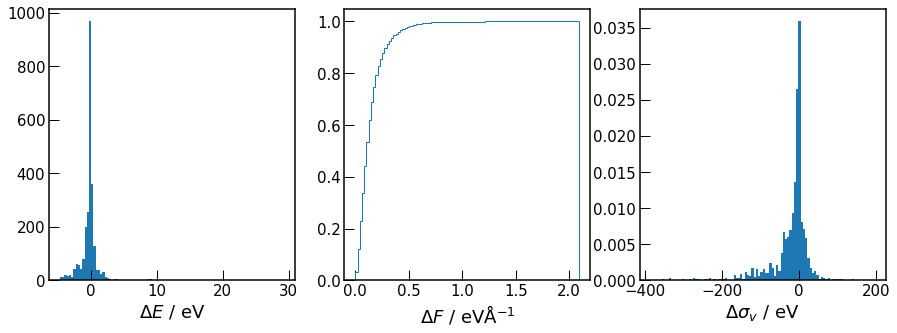

In [172]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))
m = rmse_models[0]
h1= axs.hist(m.ref_train_es - m.train_es, bins=100)

h2 = axs2.hist(np.linalg.norm(m.ref_train_flat_fs - m.train_flat_fs, axis=1),
               bins=100, cumulative=True, histtype='step', orientation='vertical', density=True)

h3 = axs3.hist((np.array([to_voigt(i)[0:3] for i in m.train_ss]) - \
                np.array([to_voigt(i)[0:3] for i in m.ref_train_ss])).mean(axis=1),
               bins=100, orientation='vertical', density=True)

axs.set(xlabel=r'$\Delta E$ / eV')
axs2.set(xlabel=r'$\Delta F$ / $\mathrm{eV \AA ^{-1}}$')
axs3.set(xlabel=r'$\Delta\sigma_v$ / $\mathrm{eV}$')

In [254]:
def outliers_missed(a, **kwargs):
    return (a.shape[0] - a[~is_outlier(a, **kwargs)].shape[0])/a.shape[0]*100

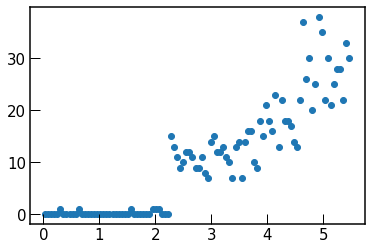

In [243]:
rho, r, bw = rho_init(a.get_positions(), a.cell.array.diagonal(), 100)
plt.scatter(r, rho)

In [279]:
is_outlier(del_e, thresh=thresh)

array([False, False, False, ..., False, False, False])

In [285]:
suspect_distances = []
suspects = [x for i_, x in enumerate(rmse_models[0].test_set) if is_outlier(del_e, thresh=thresh)[i_]]


[Atoms(symbols='Si125', pbc=True, cell=[13.7286, 13.7286, 13.7286], gap18_force=..., masses=...),
 Atoms(symbols='Si216', pbc=True, cell=[16.4743, 16.4743, 16.4743], gap18_force=..., masses=...),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=...),
 Atoms(symbols='Si125', pbc=True, cell=[13.7286, 13.7286, 13.7286], gap18_force=..., masses=...),
 Atoms(symbols='Si216', pbc=True, cell=[16.4743, 16.4743, 16.4743], gap18_force=..., masses=...),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=...),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=...),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=...),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=..., calculator=MTP(...)),
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=...),
 Atom

In [286]:
for i, val in enumerate(suspects):
    rho, r, bw = rho_init(val.get_positions(), val.cell.array.diagonal(), 100)
    suspect_distances.append( r[np.argwhere(rho>0)[0,0]] )

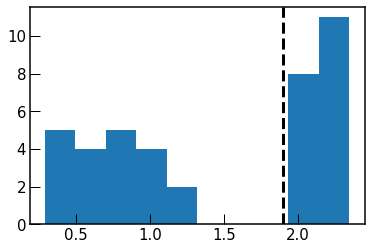

In [292]:
fig, axs = plt.subplots()
axs.hist(suspect_distances)
axs.axvline(1.9, color='k', linestyle='--')

 min distances below that of the mp are clear hear - GAP has fallen down a hole (could be the origin of the issues
 with fitting germanium or **need for looseness**?!!!!)

In [218]:
a = rmse_models[0].test_set[2601]
a.calc = g18_pot
print(a.get_potential_energy())
a.calc = MTPs_rmse[5]
print(a.get_potential_energy()), a

-10240.557597237186
266361.65946448647


(None,
 Atoms(symbols='Si64', pbc=True, cell=[10.9829, 10.9829, 10.9829], gap18_force=..., masses=..., calculator=MTP(...)))

Text(0.5, -0.3, 'MP_g18_u16_fw0.1')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


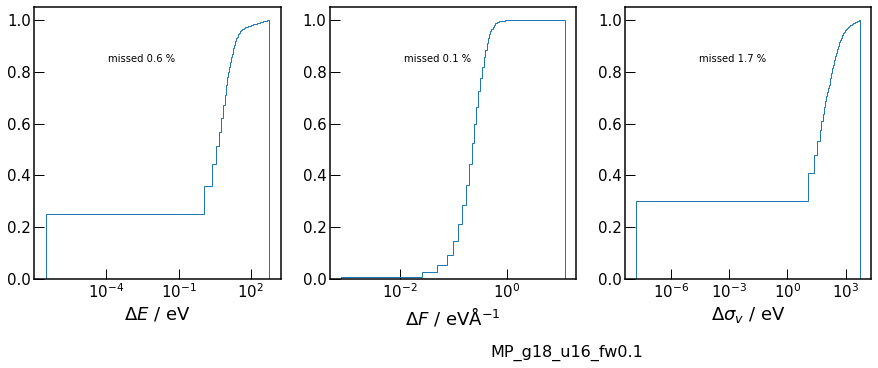

In [288]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))
m = rmse_models[0]
thresh = 100
del_e = (m.ref_es - m.es)**2 / m.atoms_lengths*1000
h1= axs.hist(del_e[~is_outlier(del_e, thresh=thresh)], bins=500, histtype='step', cumulative=True, density=True)

del_f = np.linalg.norm(m.ref_flat_fs - m.flat_fs, axis=1)
h2 = axs2.hist(del_f[~is_outlier(del_f, thresh=thresh)],
               bins=500, cumulative=True, histtype='step', orientation='vertical', density=True)

# del_s = (np.array([to_voigt(i)[0:3] for i in m.ss]) - \
#                 np.array([to_voigt(i)[0:3] for i in m.ref_ss])).mean(axis=1)
del_s = ((np.array([to_voigt(i) for i in m.ss]) - \
                np.array([to_voigt(i) for i in m.ref_ss]))**2).ravel()
h3 = axs3.hist(del_s[~is_outlier(del_s, thresh=thresh)],
               bins=500, cumulative=True, histtype='step', orientation='vertical', density=True)

axs.set_xscale('log'); axs2.set_xscale('log'); axs3.set_xscale('log')
axs.set(xlabel=r'$\Delta E$ / eV')
axs2.set(xlabel=r'$\Delta F$ / $\mathrm{eV \AA ^{-1}}$')
axs3.set(xlabel=r'$\Delta\sigma_v$ / $\mathrm{eV}$')

dels = [del_e, del_f, del_s]

for ct, i in enumerate([axs, axs2, axs3]):
    i.text(0.3, 0.8, 'missed {:3.1f} %'.format(outliers_missed(dels[ct], thresh=thresh)), transform=i.transAxes)
    
axs2.text(0.5, -0.3, '{}'.format(m.pot.name), fontsize=16)

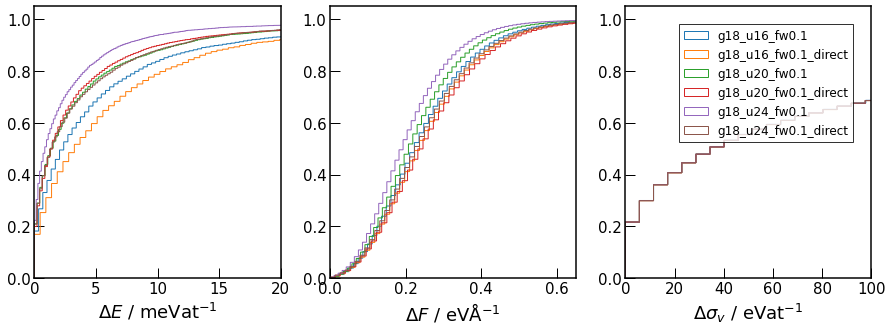

In [321]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))
choice = [4,5,6,7,8,9]
thresh = 100
del_e = []; del_f = []; del_s = []

for ct, m in enumerate([rmse_models[i] for i in choice]):
    del_e.append((m.ref_es - m.es)**2 / m.atoms_lengths*1000)
    del_f.append(np.linalg.norm(m.ref_flat_fs - m.flat_fs, axis=1))
    del_s.append(((np.array([to_voigt(i) for i in m.ss]) - \
                    np.array([to_voigt(i) for i in m.ref_ss]))**2).ravel())
    
    h1= axs.hist(del_e[-1][~is_outlier(del_e[-1], thresh=thresh)],
                 bins=1000, histtype='step', cumulative=True, density=True
                )
 
    h2 = axs2.hist(del_f[-1][~is_outlier(del_f[-1], thresh=thresh)],
                   bins=1000, cumulative=True, histtype='step', orientation='vertical', density=True)

   
    h3 = axs3.hist(del_s[-1][~is_outlier(del_s[-1], thresh=thresh)],
                   bins=1000, cumulative=True, histtype='step', orientation='vertical', density=True,
                  label=m.pot.name)

# axs.set_xscale('log'); axs2.set_xscale('log'); axs3.set_xscale('log')
axs.set(xlabel=r'$\Delta E$ / $\mathrm{meV at}^{-1}$',
       xlim=(0,20))
axs2.set(xlabel=r'$\Delta F$ / $\mathrm{eV \AA ^{-1}}$',
       xlim=(0,0.65))
axs3.set(xlabel=r'$\Delta\sigma_v$ / $\mathrm{eV at}^{-1}$',
       xlim=(0,100))
axs3.legend()

# dels = [del_e, del_f, del_s]

# for ct, i in enumerate([axs, axs2, axs3]):
#     i.text(0.3, 0.8, 'missed {:3.1f} %'.format(outliers_missed(dels[ct], thresh=thresh)), transform=i.transAxes)
    
# axs2.text(0.5, -0.3, '{}'.format(m.pot.name), fontsize=16)

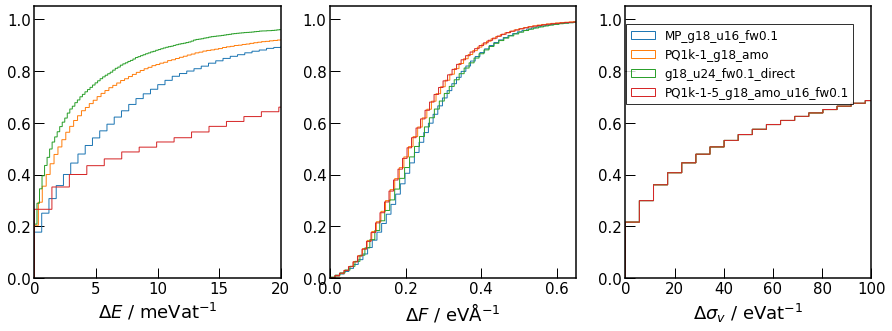

In [322]:
fig, (axs, axs2, axs3) = plt.subplots(1,3, figsize=(15,5))
choice = [0,1,-2, -1]
thresh = 100
del_e = []; del_f = []; del_s = []

for ct, m in enumerate([rmse_models[i] for i in choice]):
    del_e.append((m.ref_es - m.es)**2 / m.atoms_lengths*1000)
    del_f.append(np.linalg.norm(m.ref_flat_fs - m.flat_fs, axis=1))
    del_s.append(((np.array([to_voigt(i) for i in m.ss]) - \
                    np.array([to_voigt(i) for i in m.ref_ss]))**2).ravel())
    
    h1= axs.hist(del_e[-1][~is_outlier(del_e[-1], thresh=thresh)],
                 bins=1000, histtype='step', cumulative=True, density=True
                )
 
    h2 = axs2.hist(del_f[-1][~is_outlier(del_f[-1], thresh=thresh)],
                   bins=1000, cumulative=True, histtype='step', orientation='vertical', density=True)

   
    h3 = axs3.hist(del_s[-1][~is_outlier(del_s[-1], thresh=thresh)],
                   bins=1000, cumulative=True, histtype='step', orientation='vertical', density=True,
                  label=m.pot.name)

# axs.set_xscale('log'); axs2.set_xscale('log'); axs3.set_xscale('log')
axs.set(xlabel=r'$\Delta E$ / $\mathrm{meV at}^{-1}$',
       xlim=(0,20))
axs2.set(xlabel=r'$\Delta F$ / $\mathrm{eV \AA ^{-1}}$',
       xlim=(0,0.65))
axs3.set(xlabel=r'$\Delta\sigma_v$ / $\mathrm{eV at}^{-1}$',
       xlim=(0,100))
axs3.legend()

# Older stuff
need to go through and keep or delete

In [ ]:
db = myDB
# db = GAP_18_db
for j, M in enumerate(MTPs):
    print('Starting MTP {}'.format(j))
    if calc_flag[j]:
        for i, val in enumerate(db):

            M.calculate(val, properties=['energy', 'forces', 'stress'])
            # val.set_calculator(MTPs[0])
            # print(val.get_potential_energy())
            # print(MTPs[0].results)
            val.info['{}_energy'.format(M.name)] = M.results['energy']
            val.info['{}_virial'.format(M.name)] = M.results['stress']
            # if np.shape((MTPs[0].results['forces']))[1] != 3:
            #     print(i,val, len(i), MTPs[0].results['forces'])
            val.arrays['{}_force'.format(M.name)] = M.results['forces']
            val.set_calculator(None)
            M.results = {}

In [ ]:
GAP_18_db[0].arrays['gap18_force']
#sum([len(i) for i in GAP_18_db])*3
#np.average(flatten([i.get_atomic_numbers() for i in GAP_18_db]))

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to the GAP-18 db
GAP_18_EF = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in GAP_18_db]))]
MTP_EF_GAP_18 = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in GAP_18_db]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in GAP_18_db]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in GAP_18_db]))]
                  for j in MTPs]
GAP_18_DFT = [np.array([i.info['dft_energy']/len(i) for i in GAP_18_db]),
              np.array(flatten([i.arrays['dft_force'].flatten() for i in GAP_18_db]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in GAP_18_db]))
              ]

In [ ]:
# flattened data for DFT, GAP-18 and MTPs applied to myDB
GAP_18_EF_myDB = [np.array([i.info['{}_energy'.format('gap18')]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format('gap18')].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['gap18_virial'].flatten() for i in myDB]))]

MTP_EF_myDB = [[np.array([i.info['{}_energy'.format(j.name)]/len(i) for i in myDB]),
                  np.array(flatten([i.arrays['{}_force'.format(j.name)].flatten() for i in myDB]))]
                  #np.array(flatten([i.arrays['mtpu16_virial'].flatten() for i in myDB]))]
                  for j in MTPs]
myDB_DFT = [np.array([i.info['dft_energy']/len(i) for i in myDB]),
              np.array(flatten([i.arrays['dft_forces'].flatten() for i in myDB]))
              #np.array(flatten([i.arrays['dft_virial'].flatten() for i in myDB]))
              ]

In [ ]:
print(len(MTP_EF_GAP_18[0][1]))
len(GAP_18_DFT[1])

In [ ]:
# rmses for the GAP-18 db
rmses_MTP_DFT = [[rms_dict(i[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))] for i in MTP_EF_GAP_18]
rmses_MTP_GAP18 = [[rms_dict(i[j], GAP_18_EF[j]) for j in range(len(GAP_18_EF))] for i in MTP_EF_GAP_18]
rmses_GAP_DFT = [rms_dict(GAP_18_EF[j], GAP_18_DFT[j]) for j in range(len(GAP_18_DFT))]

In [ ]:
rmses_MTP_DFT

In [ ]:
rmses_MTP_GAP18

In [ ]:
rmses_GAP_DFT

In [ ]:
delX = [myDB[0].info['dft_energy'] - GAP_18_db[0].info['dft_energy'],
        0,
        0] # virial

In [ ]:
# rmses for myDB as validation set, need to adjust for different level of DFT (or just compare forces)
rmses_MTP_DFT_myDB = [[rms_dict(i[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))] for i in MTP_EF_myDB]
rmses_MTP_GAP18_myDB = [[rms_dict(i[j], GAP_18_EF_myDB[j]) for j in range(len(GAP_18_EF_myDB))] for i in MTP_EF_myDB]
rmses_GAP_DFT_myDB = [rms_dict(GAP_18_EF_myDB[j], myDB_DFT[j] - delX[j]) for j in range(len(myDB_DFT))]

In [ ]:
rmses_MTP_DFT_myDB

In [ ]:
rmses_MTP_GAP18_myDB

In [ ]:
rmses_GAP_DFT_myDB

## Plotting the RMSES
need to think about the best way to present this

In [ ]:
TS = [16, 20, 24]
# showing the RMSEs for different tensor sizes, compared to DFT, GAP-18 prediction and direct MTP

fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]])*1000,
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP v. GAP-18 on myDB', zorder=5)

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]])*1000,
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18 on myDB', zorder=5)
axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')




axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP on GAP-18_DB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[:2]]),
                yerr=None, fmt='^--', color='r', markersize=6, label='GAP-MTP on myDB', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18_myDB[2:]]),
                yerr=None, fmt='^--', color='Indigo', markersize=6, label='DFT-MTP on myDB', zorder=5)

axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[0].xaxis.labelpad = 7
axs[1].legend(title='all rms v. GAP-18 pot')
#axs[1].legend(bbox_to_anchor=(0.6,1.05))
# axs[1].xaxis.labelpad = 20

plt.tight_layout()
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rmse_vGAP18.png', dpi=100, bbox_inches='tight')

In [ ]:
print(rms_dict(MTP_EF_myDB[0][0], GAP_18_EF_myDB[0]))
rms_dict(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0])


In [ ]:
fig, axs = plt.subplots()
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[0][0], s=2, label='MTP-16', color='g', zorder=2)
axs.scatter(GAP_18_EF_myDB[0], MTP_EF_myDB[1][0], s=2, label='MTP-20', color='b')
# axs.plot(x:=np.linspace(-168.8,-168.0), x, color='k', linewidth=0.5)
axs.plot(x:=np.linspace(-163,-162.2), x, color='k', linewidth=0.5)
axs.set(xlim=(-163,-162.2), ylim=(-163,-162.2))
axs.legend(title='GAP-MTP v. GAP-18 on myDB', markerscale=3)
axs.set(xlabel='GAP-18 Energy  / $\mathrm{eV\AA^{-1}}$', ylabel='MTP prediction / $\mathrm{eV\AA^{-1}}$')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

# axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_GAP_DFT])*1000,
#                 yerr=None, fmt='o--', color='k', markersize=6, label='GAP-18 v. DFT', zorder=5)
#
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[:2]])*1000,
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_DFT[2:]])*1000,
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[:2]])*1000,
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[0].errorbar(TS[:2], np.array([i[0]['rmse'] for i in rmses_MTP_GAP18[2:]])*1000,
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[:2]]),
                yerr=None, fmt='o--', color='r', markersize=6, label='GAP-MTP v. DFT', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_DFT[2:]]),
                yerr=None, fmt='o--', color='Indigo', markersize=6, label='DFT-MTP v. DFT')

axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[:2]]),
                yerr=None, fmt='s--', color='r', markersize=6, label='GAP-MTP v. GAP-18', zorder=5)
axs[1].errorbar(TS[:2], np.array([i[1]['rmse'] for i in rmses_MTP_GAP18[2:]]),
                yerr=None, fmt='s--', color='Indigo', markersize=6, label='DFT-MTP v. GAP-18', zorder=5)


axs[0].set(xlabel='MTP setting', ylabel='Energy RMSE / meV')
axs[1].set(xlabel='MTP setting', ylabel='Force RMSE / $\mathrm{eV\AA^{-1}}$')
axs[0].tick_params(axis="both",direction="in", left="off",labelleft="on")
axs[1].tick_params(axis="both",direction="in", left="off",labelleft="on")
# axs[0].axhline(rmses_GAP_DFT[0]['rmse'],  color='k')
plt.tight_layout()
axs[1].legend(title='All on GAP-18 DB', bbox_to_anchor=(1.05,0.5))
# axs[1].xaxis.labelpad = 20
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rmse_vDFT.png', dpi=100, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.subplots_adjust(hspace=0.05)

In [ ]:
rs = [ring_statistics(i.df['Configs'][240000], cutoff=2.7) for i in MTP_md]
rs = pad_rstats(rs)

In [ ]:
rs_G18 = ring_statistics(GAP_18_md.df['Configs'][240000], cutoff=2.7)
rs_G18 = pad_rstats([rs_G18])

In [ ]:
rs_G18

In [ ]:
np.arange(2, len(rs_G18[0])), rs_G18[0][2:]

In [ ]:
order = [0, 2, 1, 3]
colors = ['darkred', 'red', 'darkblue', 'slateblue']
markers = ['x', '+', 'o', 's']
fig, axs = plt.subplots()
# colormap = plt.get_cmap('viridis')
# colors = [colormap(i) for i in np.linspace(F_reg[0], F_reg[-1], len(F_reg))]
for i, val in enumerate(order):
    axs.plot(np.arange(2, len(rs[0])), rs[val][2:], label=MTP_md[val].label,
    color=colors[i], marker=markers[i])
axs.plot(np.arange(2, len(rs_G18[0])), rs_G18[0][2:], label=GAP_18_md.label, marker='^', linestyle='--',
         color='k')
    # axs.set(xlim=(2,11), ylim=(-5,5))
axs.legend()
axs.set(xlabel='Ring size', ylabel='Count')
axs.tick_params(axis="both",direction="in", left="off",labelleft="on")
plt.tight_layout()
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/rstat_4.png', dpi=100, bbox_inches='tight')

In [ ]:
for i in MTP_md:
    i.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                    rings_dir='Sq_'+i.label,
                    opts={'Angles':True},
                    rings_in={'species':['Si']},
                    read_only=True)
    l_sel = [i for i in range(90)]
    a_sel = [i for i in range(90,110)]
    i.bin_fit(s_selection=l_sel, q_selection=[0.5,12], nbins=200)
    i.bin_fit(s_selection=a_sel, q_selection=[0.5,12], nbins=200)
    i.bin_bond_angle(s_selection=l_sel)
    i.bin_bond_angle(s_selection=a_sel)

In [ ]:
GAP_18_md.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                rings_dir='/u/vld/hert5155/jup_remote/Ge_od/MD_runs/Si_litDB_full_4000/Sq_rings_1000_001',
                opts={'Angles':True},
                rings_in={'species':['Si']},
                read_only=True)
l_sel = [i for i in range(90)]
a_sel = [i for i in range(90,110)]
GAP_18_md.bin_fit(s_selection=l_sel, q_selection=[0.5,12])
GAP_18_md.bin_fit(s_selection=a_sel, q_selection=[0.5,12])
GAP_18_md.bin_bond_angle(s_selection=l_sel)
GAP_18_md.bin_bond_angle(s_selection=a_sel)


In [ ]:
aSi_exp_Sq = np.genfromtxt('/u/vld/hert5155/jup_remote/Ge_od/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T

In [ ]:
linestyles = ['-', '--', '-.', ':']

In [ ]:
fig, axs = plt.subplots()
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].Sq_x_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct], linestyle=linestyles[ct])

axs.errorbar(*GAP_18_md.Sq_x_av[1], yerr=None,
            label=GAP_18_md.label, color='k')
axs.plot(*aSi_exp_Sq, color='Gray', linewidth=2, label='Exp. a-Si')
axs.legend(bbox_to_anchor=(1, 1.04), loc='upper right')
axs.set(xlabel= r'Q / $\mathrm{{\AA}}^{-1}$', ylabel='$\mathrm{S(Q)}$')
axs.set(xlim=(1.25,3), ylim=(0,1.9))
plt.tight_layout()

fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/amo_Sq_4_zoom.png', dpi=100, bbox_inches='tight')

In [ ]:
# BADFs
fig, axs = plt.subplots()
axs.plot(*GAP_18_md.bond_angle_av[0], color='k', linestyle='--')
axs.plot(*GAP_18_md.bond_angle_av[1], label=GAP_18_md.label, color='k')
for ct, i in enumerate(order):
    axs.errorbar(*MTP_md[i].bond_angle_av[0], yerr=None,
                 color=colors[ct])
    axs.errorbar(*MTP_md[i].bond_angle_av[1], yerr=None,
                label=MTP_md[i].label, color=colors[ct])

axs.legend(title='- amo\n-- liquid')
axs.set(xlabel='Angle / deg', ylabel='')
fig.savefig('/u/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/volker_figures/BADF_4.png', dpi=100, bbox_inches='tight')

## Bimodality of GAP-predicted errors

In [35]:
gldir = '/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/rmses/gap_local_var/'

In [15]:
with open('/home/tridymite/vld/hert5155/jup_remote/Ge_od/GAP_to_MTP/rmses/gap_local_var/LOCAL_E_traj_compress_GAP-18_ALL_frame_200_relabel_SOAP.xyz', 'r') as f:
    VLDg18_ff = list(read_xyz(f))[0]

In [36]:
from os.path import join
with open(join(gldir, 'run_100k_u16_fw0.1_PQ1k_G18_scratch_indirect_relabel_SOAP_B_finalframe_GAPLV.xyz'), 'r') as f:
    PQ1k_rand_16 = list(read_xyz(f))[0]

In [62]:
with open(join(gldir, 'run_100k_u16_m1.5_fw0.1_PQ1k-1_amo_G18_scratch_relabel_SOAP_B_ff.xyz'), 'r') as f:
    PQ1k_amo_16 = list(read_xyz(f))[0]

In [60]:
with open(join(gldir, 'run_100k_u16_fw0.1_indirect_ff.xyz'), 'r') as f:
    u16_g18db = list(read_xyz(f))[0]

In [105]:
with open(join(gldir, 'run_100k_u24_m1.5_fw0.1_PQ1k_rand_G18_retrain_relabel_SOAP_B_ff.xyz'), 'r') as f:
    u24_rand_retrain = list(read_xyz(f))[0]

In [81]:
import scipy as sci

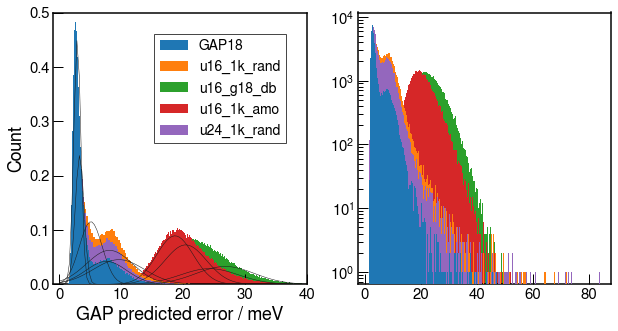

In [112]:
fig, (axs, axs2) = plt.subplots(1,2, figsize=(10,5))
dat = [VLDg18_ff, PQ1k_rand_16, u16_g18db, PQ1k_amo_16, u24_rand_retrain]
labels = ['GAP18', 'u16_1k_rand', 'u16_g18_db', 'u16_1k_amo', 'u24_1k_rand']
zs = [5, 4, 1, 2, 4.5]

for i, val in enumerate(dat):
    axs.hist(np.sqrt(val.arrays['GAP18_variance'])*1000, bins=300, label=labels[i], zorder=zs[i], density=True)
    axs2.hist(np.sqrt(val.arrays['GAP18_variance'])*1000, bins=300, label=labels[i], zorder=zs[i])
    mixture = GaussianMixture(n_components=2).fit(1000*np.sqrt(val.arrays['GAP18_variance']).reshape(-1, 1))
    means_hat = mixture.means_.flatten()
    weights_hat = mixture.weights_.flatten()
    sds_hat = np.sqrt(mixture.covariances_).flatten()
#     axs.plot(x := np.linspace(0,40,100), sum([weights_hat[i]*sci.stats.norm(means_hat[i],sds_hat[i]).pdf(x)
#                                               for i in range(len(means_hat))]), zorder=10, color='k')
    vals = [weights_hat[i]*sci.stats.norm(means_hat[i],sds_hat[i]).pdf(x)
                                               for i in range(len(means_hat))]
    for i in vals:
        axs.plot(x := np.linspace(0,40,100), i, zorder=10, color='k', linewidth=0.5)

axs2.set_yscale('log')
axs.set(ylim=(0,0.5), xlim=(-1,40), xlabel='GAP predicted error / meV', ylabel='Count')
# axs2.set(ylim=(0,4000))
axs.legend()

In [79]:
sns.reset_orig()

In [73]:
from sklearn.mixture import GaussianMixture
mixture = GaussianMixture(n_components=2).fit(1000*np.sqrt(VLDg18_ff.arrays['GAP18_variance']).reshape(-1, 1))
means_hat = mixture.means_.flatten()
weights_hat = mixture.weights_.flatten()
sds_hat = np.sqrt(mixture.covariances_).flatten()

print(mixture.converged_)
print(means_hat)
print(sds_hat)
print(weights_hat)

True
[2.89544178 7.58321844]
[0.57602462 3.29917887]
[0.65160578 0.34839422]


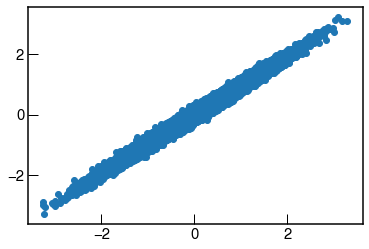

In [120]:
fig, axs = plt.subplots()
axs.scatter(u24_rand_retrain.arrays['GAP18_force'],
            u24_rand_retrain.arrays['u24_m1.5_fw0.1_PQ_rand_retrain_fromGAP18db.mtp_force'])

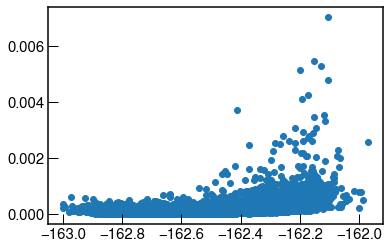

In [126]:
fig, axs = plt.subplots()
axs.scatter(u24_rand_retrain.arrays['GAP18_energies'],
            u24_rand_retrain.arrays['GAP18_variance'])